# Project 5: Dream Team LLC

Project members: Ani Zotti, Ashanti Jabri, Brian Cho

In today's digital society, parents and officials have actively fought child exploitation on the internet. Online enticement occurs across all platforms, this can involve illegal video content of minors, online enticement of children, or the transaction of a child's sexual images to others. Snapchat is one of many social media applications where age verification would play a major role. Snapchat is particularly dangerous for children because the snaps/media content are quickly deleted. This makes it incredibly difficult for parents/officials to see what the child is doing with the application. Age verification processes and the Children's Online Privacy Protection Rule are some practices that were designed to restrict adult content to minors. However, many age verification processes can be easily bypassed (children can create fake emails, parents can lie, etc.). In this project, our team will explore how we can build a model that can take an image and classify whether it is a child or an adult.

In this project, our team utilized three different deep neural networks to classify photos as either children or adults (trained Convolutional Neural Network, ResNet50, and VGG-16). Success was determined through a variety of classification metrics: accuracy, loss, precision, and recall.

# Import Libraries

---






In [ ]:
#Magic and Console Commands
%load_ext tensorboard
!pip install keras-metrics

#System Libraries
import os
import datetime 
import sys 
from pathlib import Path

#Standard Python Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Image Specific Libraries
import cv2
import PIL
from PIL import Image
from PIL import ImageFilter
from scipy import ndimage

#Tensorflow and Keras Libraries
import tensorflow as tf
import keras
from keras import metrics
from keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from keras import regularizers, optimizers
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras_metrics import binary_average_recall, binary_f1_score, binary_false_negative, binary_false_positive, binary_precision, binary_recall, binary_true_negative, binary_true_positive
from keras.applications.resnet50 import ResNet50
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.applications import vgg16



#Scikit Lean Libraries
from sklearn.model_selection import train_test_split

#Google Drive Mount
from google.colab import drive
drive.mount('/content/drive')
os.mkdir('/content/train')

Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Instantiate Global Functions

---

In [ ]:
#Functions

def image_viewer(image_index):
  img_view = PIL.Image.open(image_index)
  return img_view

#-----------------------------------------------------------

def predictImage(filename,model):
    img = image.load_img(filename, target_size=(224, 224))
    plt.imshow(img)
    
    img_array = image.img_to_array(img)
   
    img_batch = np.expand_dims(img_array, axis=0)

    img_preprocessed = img_batch/255.

    prediction = model.predict(img_preprocessed)

    prediction = np.max(prediction, axis=1).round()

    print(prediction)
    if prediction >= .51:
        
        plt.xlabel("adult",fontsize=30)
        
    
    else:
        
        plt.xlabel("child",fontsize=30)

#--------------------------------------------------------------------

def reset_model(model):
    for layer in model.layers:
        if isinstance(layer, tf.keras.Model): #if you're using a model as a layer
            reset_weights(layer) #apply function recursively
            continue

        #where are the initializers?
        if hasattr(layer, 'cell'):
            init_container = layer.cell
        else:
            init_container = layer

        for key, initializer in init_container.__dict__.items():
            if "initializer" not in key: #is this item an initializer?
                  continue #if no, skip it

            # find the corresponding variable, like the kernel or the bias
            if key == 'recurrent_initializer': #special case check
                var = getattr(init_container, 'recurrent_kernel')
            else:
                var = getattr(init_container, key.replace("_initializer", ""))

            if var is not None:
                var.assign(initializer(var.shape, var.dtype))

#--------------------------------------------------------------------

def get_bottleneck_features(model, input_imgs):
    features = model.predict(input_imgs, verbose=0)
    return features
    

# Import Datasets and Data Cleaning

---

The dataset used was the UTKFace dataset. The dataset consists of over 20,000 images with annotations of age, gender, and ethnicity with ages that range from 0 to 116 years old (https://susanqq.github.io/UTKFace/).

The UTKFace Dataset had images that were already cleaned and labelled. The format of the labels is as follows:

[age]\_[gender]\_[race]\_[date&time].jpg

The team created a dataframe which included the file name and the corresponding age that is associated with the file. Ages 0-17 were defined as children and ages 18 and up were defined as adults.

In [ ]:
#Unzip Image Datasets
!unzip '/content/drive/MyDrive/project_5_group_3/data/UTKFace.zip'

In [ ]:
#Creating Datasets and Cleaning
path = '/content/UTKFace'
temp_path = Path(path)
faces = list(temp_path.glob('*.jpg'))

#----------------------------------------------

df = pd.DataFrame(columns = ['images','age'])

for img in faces: 
  new_img = str(img)
  img = new_img.split("/")

  img_name = img[3]
  img = img_name.split("_")

  img[0] = int(img[0])
  if img[0] > 17:
    img[0] = '1'
  else: img[0] = '0'

  df2 = {'images': new_img, 'age': img[0]}
  df = df.append(df2, ignore_index = True)

df.head()

#----------------------------------------------

,images,age


# Feature Engineering and Train Test Splits

---

In [ ]:
#Initial Train Test Split
X = df['images']
y = df['age']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=808, stratify=y)

d_train = pd.DataFrame({
    'images':X_train,
     'age': y_train})

#---------------------------------------------------------
#Second Train Test Split for Validation Data
x_data = d_train['images']
y_data = d_train['age']
X_tr, X_val, y_tr, y_val = train_test_split(x_data, y_data, random_state=808, stratify=y_data)

#---------------------------------------------------------
#Creating Train Dataset
train= pd.DataFrame({
    'images':X_train,
     'age': y_train})

#Creating Validation Dataset
val = pd.DataFrame({
    'images':X_val,
     'age': y_val})

#Creating Test Dataset
test = pd.DataFrame({
    'images':X_test,
     'age': y_test})

#---------------------------------------------------------

print(f'Train set {train.shape}')
print(f'Val set {val.shape}')
print(f'Test set {test.shape}')

The original dataset had an imbalance of classes, less than 20% of the data had faces that were of ages 18 and below.

In [ ]:
#plot of distribution of unbalanced classes
plt.figure(figsize=(10,8))
df['age'].value_counts().plot(kind='bar')
plt.title('Distribution of Classes', fontsize = 20)
plt.xticks([0,1],labels=['Adult','Child'], rotation=0, fontsize=15)
plt.ylabel('Value Count', fontsize=15);

In order to balance the classes, we augmented images from ages 0-17 and incorporated them into the dataset. The dataset had an even balance of photos that incorporated child and adult faces.

In [ ]:
#Augmenting Images to Address Imbalanced Classes
# ---------------------------------------------------------
os.mkdir('/content/train6')
filelist = train['images'].loc[(train['age']=='0')].tolist()
for imagefile in filelist:
    img_n = imagefile.split("/")[3]
    img_num = img_n.split(".")[0]
    os.chdir('/content/UTKFace/')
    img_name = imagefile.split('/')[3]
    im=Image.open(imagefile)
    im=im.convert("RGB")
    im_unsharp=im.filter(ImageFilter.UnsharpMask)
    img_fliplr = np.fliplr(im)
    rotate_2 = Image.fromarray(ndimage.rotate(img_fliplr, -40, reshape=False))
    rotate_3 = Image.fromarray(ndimage.rotate(im, -40, reshape=False))
    rotate_4 = Image.fromarray(ndimage.rotate(img_fliplr, 40, reshape=False))
    os.chdir('/content/train6')
    im_unsharp.save(img_num+"5.jpg")
    rotate_2.save(img_num+"7.jpg")
    rotate_3.save(img_num+"8.jpg")
    rotate_4.save(img_num+"9.jpg")

#---------------------------------------------------------

path_aug = '/content/train6'
temp_path_aug = Path(path_aug)
faces_aug = list(temp_path_aug.glob('*.jpg'))

for img in faces_aug:
  new_img = str(img)
  img = new_img.split("/")

  img_name = img[3]
  img = img_name.split("_")

  img[0] = int(img[0])
  if img[0] > 17:
    img[0] = '1'
  else: img[0] = '0'

  df3 = {'images': new_img, 'age': img[0]}
  train = train.append(df3, ignore_index = True)

train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)
val.reset_index(drop=True, inplace=True)

print(train.shape)
print(train['age'].value_counts(normalize=True))

(31265, 2)
0    0.539101
1    0.460899
Name: age, dtype: float64


In [ ]:
#plot of distribution of classes after img augmentation
plt.figure(figsize=(10,8))
train['age'].value_counts().plot(kind='bar')
plt.title('Distribution of Classes', fontsize = 20)
plt.xticks([0,1],labels=['Adult','Child'], rotation=0, fontsize=15)
plt.ylabel('Value Count', fontsize=15);

In [ ]:
os.chdir('./')

Once the team balanced the classes, the dataset was split between train, validation, and testing datasets.

In [ ]:
#Universal Values
batch = 32
img_height = 224
img_width = 224

#---------------------------------------------------------
#Creating Our Image Data Generators
train_gen= ImageDataGenerator(rescale=1/255)
test_gen= ImageDataGenerator(rescale=1/255)

train_data = train_gen.flow_from_dataframe(
    # color_mode = 'grayscale',
    dataframe = train,
    x_col = 'images',
    y_col = 'age',
    seed = 808,
    batch_size = batch,
    shuffle = True,
    class_mode = 'binary',
    target_size = (img_height, img_width)
)

test_data = test_gen.flow_from_dataframe(
    dataframe = test,
    x_col = 'images',
    y_col = 'age',
    seed = 808,
    batch_size = 1,
    shuffle = False,
    class_mode = None,
    target_size = (img_height, img_width)
)

val_data = train_gen.flow_from_dataframe(
    # color_mode = 'grayscale',
    dataframe = val,
    x_col = 'images',
    y_col = 'age',
    seed = 808,
    batch_size = 1,
    shuffle = True,
    class_mode = 'binary',
    target_size = (img_height, img_width)
)

In the modeling process, the team utilized three models. The Convolutional Neural Network model that was trained, the ResNet50 model, and the VGG-16 model. Transfer learning was utilized on the ResNet50 and VGG-16 models in order to classify photos as adults or children.

# Convolutional Neural Network

---

In [ ]:
!rm -rf ./logs/

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto', restore_best_weights=True)

log_dir = "/content/drive/MyDrive/project_5_group_3/data/Models/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [ ]:
from keras.optimizers import Adam
opt = Adam(lr=0.001)

model = Sequential()

#1st Convolutional Layer
model.add(layers.Conv2D(32, (5,5), activation = 'relu', padding = 'same', input_shape = (img_height, img_width, 3)))
model.add(BatchNormalization())
model.add(layers.AveragePooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

#2nd Convolutional Layer
model.add(layers.Conv2D(64, (5,5), padding = 'same', activation = 'relu'))
model.add(BatchNormalization())
model.add(layers.AveragePooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(layers.Dropout(.2))

#3rd Convolutional Layer
model.add(layers.Conv2D(128, (5,5), activation = 'relu', padding = 'same', kernel_regularizer = 'l2'))
model.add(BatchNormalization())
model.add(layers.AveragePooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(layers.Dropout(.2))

#4th Convolutional Layer
model.add(layers.Conv2D(256, (5,5), padding = 'same', activation = 'relu'))
model.add(BatchNormalization())
model.add(layers.AveragePooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

#5th Convolutional Layer
model.add(layers.Conv2D(128, (3,3), padding = 'same', activation = 'relu'))
model.add(BatchNormalization())
model.add(layers.AveragePooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

#6th Convolutional Layer
model.add(layers.Conv2D(32, (3,3), activation = 'relu'))
model.add(BatchNormalization())
model.add(layers.AveragePooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(layers.ZeroPadding2D(padding=(1, 1)))
model.add(layers.AveragePooling2D(pool_size=(2,2)))
model.add(layers.GlobalAveragePooling2D())

#Flattening
model.add(layers.Flatten())

#Fully Connected Layer
model.add(layers.Dense(512, activation = 'relu'))
model.add(BatchNormalization())

model.add(layers.Dense(1, activation = 'sigmoid'))

model.compile(optimizer = opt, 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy', 
                         metrics.Precision(), metrics.Recall(), 
                         metrics.AUC(),
                         metrics.FalseNegatives(), metrics.FalsePositives(),
                         metrics.TrueNegatives(),
                         metrics.TruePositives()])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      2432      
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 224, 32)      128       
_________________________________________________________________
average_pooling2d (AveragePo (None, 112, 112, 32)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 112, 112, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      51264     
_________________________________________________________________
batch_normalization_2 (Batch (None, 112, 112, 64)      256       
_________________________________________________________________
average_pooling2d_1 (Average (None, 56, 56, 64)       

In [ ]:
results = model.fit(train_data,
                    validation_data=val_data, 
                    epochs=100,
                    callbacks=[tensorboard_callback, early_stop],
                    batch_size=32)

Epoch 1/100
978/978 [==============================] - 90s 89ms/step - loss: 0.5658 - accuracy: 0.8578 - precision_3: 0.8204 - recall_3: 0.8810 - auc_3: 0.9272 - false_negatives_1: 738.4321 - false_positives_1: 1221.1645 - true_negatives_1: 7204.9193 - true_positives_1: 6502.9755 - val_loss: 0.5565 - val_accuracy: 0.8201 - val_precision_3: 0.8187 - val_recall_3: 0.9992 - val_auc_3: 0.8129 - val_false_negatives_1: 3.0000 - val_false_positives_1: 797.0000 - val_true_negatives_1: 46.0000 - val_true_positives_1: 3600.0000
Epoch 2/100
978/978 [==============================] - 83s 85ms/step - loss: 0.2185 - accuracy: 0.9263 - precision_3: 0.8973 - recall_3: 0.9478 - auc_3: 0.9730 - false_negatives_1: 375.3534 - false_positives_1: 792.2584 - true_negatives_1: 7687.4923 - true_positives_1: 6824.7365 - val_loss: 0.2690 - val_accuracy: 0.9089 - val_precision_3: 0.9210 - val_recall_3: 0.9709 - val_auc_3: 0.9226 - val_false_negatives_1: 105.0000 - val_false_positives_1: 300.0000 - val_true_negati

In [ ]:
# model.save('/content/drive/MyDrive/project_5_group_3/data/Models/cnn')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/project_5_group_3/data/Models/cnn/assets


# CNN Evaluation


---



In [ ]:
model.evaluate(train_data, verbose=1)

978/978 [==============================] - 49s 50ms/step - loss: 0.0315 - accuracy: 0.9945 - precision_3: 0.9914 - recall_3: 0.9967 - auc_3: 0.9999 - false_negatives_1: 47.0000 - false_positives_1: 125.0000 - true_negatives_1: 16730.0000 - true_positives_1: 14363.0000


[0.031532756984233856,
 0.9944986701011658,
 0.9913721680641174,
 0.9967383742332458,
 0.9998643398284912,
 47.0,
 125.0,
 16730.0,
 14363.0]

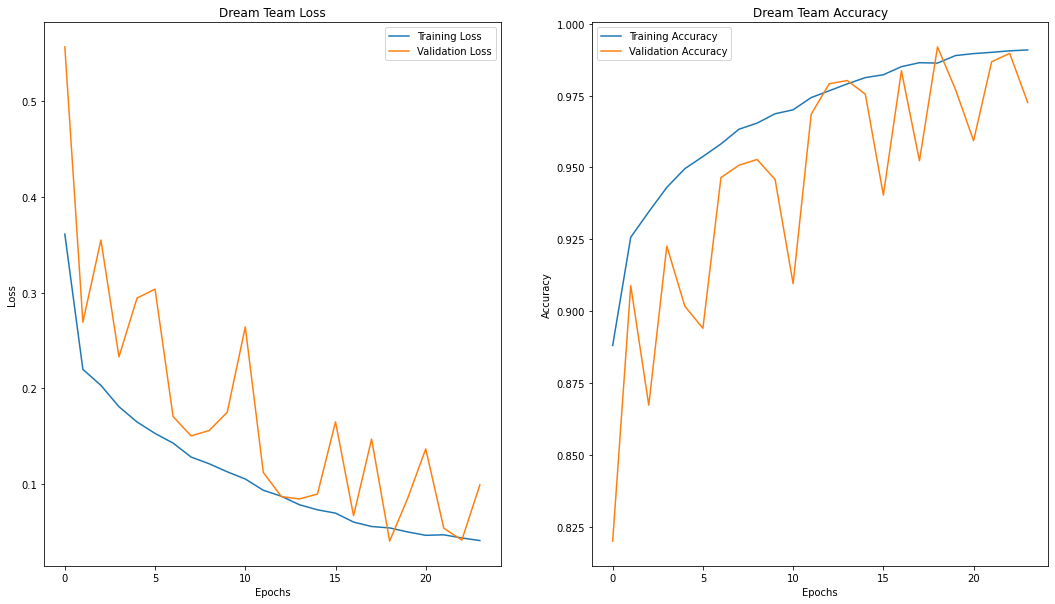

In [ ]:
f, axs = plt.subplots(1,2,figsize=(18,10))
axs[0].plot(results.history['loss'],label = 'Training Loss')
axs[0].plot(results.history['val_loss'], label = 'Validation Loss')
axs[1].plot(results.history['accuracy'], label = 'Training Accuracy')
axs[1].plot(results.history['val_accuracy'], label = 'Validation Accuracy')
axs[0].set(xlabel='Epochs',ylabel='Loss', title='Dream Team Loss')
axs[1].set(xlabel = 'Epochs', ylabel='Accuracy', title = 'Dream Team Accuracy')
axs[1].legend(labels = ['Training Accuracy', 'Validation Accuracy'])
axs[0].legend(labels = ['Training Loss', 'Validation Loss'])
plt.show();

In [ ]:
# %tensorboard --logdir logs/fit

In [ ]:
STEP_SIZE_TEST=test_data.n//test_data.batch_size
test_data.reset()
pred=model.predict_generator(test_data,
steps=STEP_SIZE_TEST,
verbose=1)

filenames=test_data.filenames
predict_df=pd.DataFrame({"Filename":filenames,
                      "Predictions":np.max(pred, axis=1).round()})
predict_df.to_csv("results.csv",index=False)

predict_df

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


5927/5927 [==============================] - 45s 7ms/step


,Filename,Predictions
0,/content/UTKFace/29_1_3_20170104232940018.jpg.chip.jpg,1.0
1,/content/UTKFace/31_1_2_20170104234746818.jpg.chip.jpg,1.0
2,/content/UTKFace/26_1_2_20170116184737269.jpg.chip.jpg,1.0
3,/content/UTKFace/32_1_3_20170109141353848.jpg.chip.jpg,1.0
4,/content/UTKFace/35_0_0_20170104201512505.jpg.chip.jpg,0.0
...,...,...
5922,/content/UTKFace/61_0_0_20170111171747571.jpg.chip.jpg,1.0
5923,/content/UTKFace/20_1_4_20170103225149441.jpg.chip.jpg,1.0
5924,/content/UTKFace/52_0_1_20170111204341094.jpg.chip.jpg,1.0
5925,/content/UTKFace/26_1_3_20170119180937252.jpg.chip.jpg,1.0


[10.]


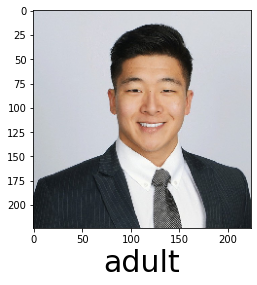

In [ ]:
predictImage('/content/drive/MyDrive/1614809012122.jpeg',vgg_model)

# ResNet50 Transfer Learning
### We will attempt to Increase our models performance by leveraging the ResNet50 model through Transfer Learning. 
----

In [ ]:
res_model = keras.models.load_model('/content/drive/MyDrive/project_5_group_3/data/Models/resnet_model')

In [ ]:
res = ResNet50(include_top=False, weights='imagenet', 
                                     input_shape=(img_height, img_width, 3))

output = res.layers[-1].output
output = keras.layers.Flatten()(output)
res_model = Model(res.input, output)

res_model.trainable = False
for layer in res_model.layers:
    layer.trainable = False
    
import pandas as pd
pd.set_option('max_colwidth', None)
layers = [(layer, layer.name, layer.trainable) for layer in res_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

,Layer Type,Layer Name,Layer Trainable
0,<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f081ea4bf90>,input_4,False
1,<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7f081e9e1d10>,conv1_pad,False
2,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f0832e9ecd0>,conv1_conv,False
3,<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f0832777f90>,conv1_bn,False
4,<tensorflow.python.keras.layers.core.Activation object at 0x7f08327789d0>,conv1_relu,False
...,...,...,...
171,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f081e728d90>,conv5_block3_3_conv,False
172,<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f081e735e50>,conv5_block3_3_bn,False
173,<tensorflow.python.keras.layers.merge.Add object at 0x7f081e944a10>,conv5_block3_add,False
174,<tensorflow.python.keras.layers.core.Activation object at 0x7f081e6d71d0>,conv5_block3_out,False


In [ ]:
# from tensorflow.keras import layers
# opt = Adam(lr=0.001)
# model = Sequential()
# model.add(res)
# model.add(layers.Flatten())
# model.add(layers.Dense(1, activation='sigmoid'))

# model.compile(loss='binary_crossentropy',
#               optimizer=opt,
#               metrics=['accuracy', 
#                          metrics.Precision(), metrics.Recall(), 
#                          metrics.AUC(),
#                          metrics.FalseNegatives(), metrics.FalsePositives(),
#                          metrics.TrueNegatives(),
#                          metrics.TruePositives()])

In [ ]:
# res_results = model.fit(train_data,
#                     validation_data=val_data, 
#                     epochs=100,
#                     callbacks=[tensorboard_callback, early_stop],
#                     batch_size=32)

In [ ]:
res_model.evaluate(val_data, verbose=1)

4446/4446 [==============================] - 50s 11ms/step - loss: 0.1561 - accuracy: 0.9402 - precision_4: 0.9436 - recall_4: 0.9850 - auc_4: 0.9699 - false_negatives_2: 54.0000 - false_positives_2: 212.0000 - true_negatives_2: 631.0000 - true_positives_2: 3549.0000


[0.15607814490795135,
 0.94017094373703,
 0.9436320066452026,
 0.9850124716758728,
 0.9698512554168701,
 54.0,
 212.0,
 631.0,
 3549.0]

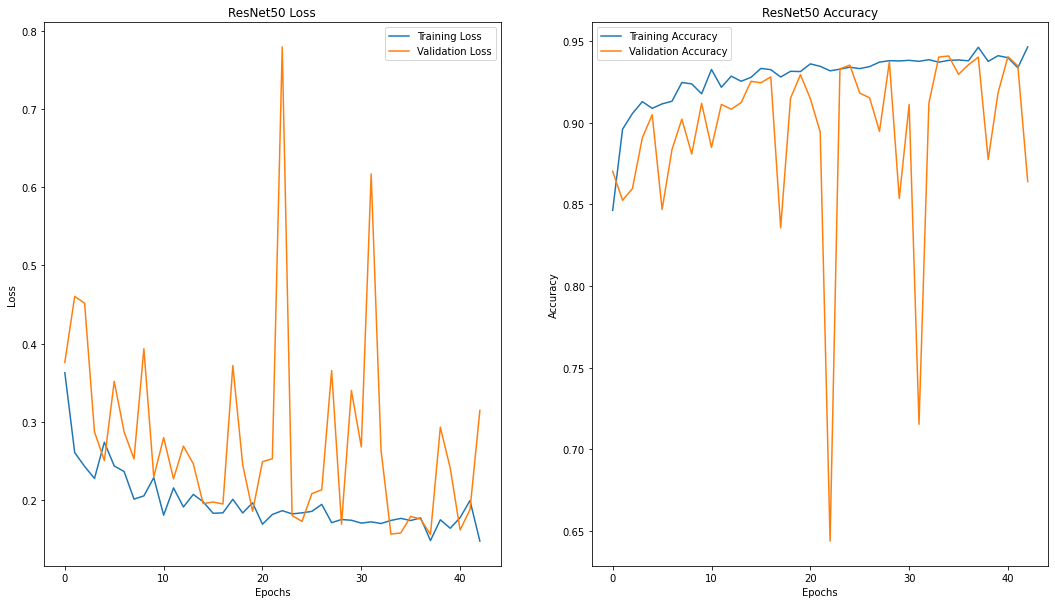

In [ ]:
f, axs = plt.subplots(1,2,figsize=(18,10))
axs[0].plot(res_results.history['loss'],label = 'Training Loss')
axs[0].plot(res_results.history['val_loss'], label = 'Validation Loss')
axs[1].plot(res_results.history['accuracy'], label = 'Training Accuracy')
axs[1].plot(res_results.history['val_accuracy'], label = 'Validation Accuracy')
axs[0].set(xlabel='Epochs',ylabel='Loss', title='ResNet50 Loss')
axs[1].set(xlabel = 'Epochs', ylabel='Accuracy', title = 'ResNet50 Accuracy')
axs[1].legend(labels = ['Training Accuracy', 'Validation Accuracy'])
axs[0].legend(labels = ['Training Loss', 'Validation Loss'])
plt.show();

In [ ]:
# model.save('/content/drive/MyDrive/project_5_group_3/data/Models/resnet_model')

# VGG - 16 Feature Extraction

### We will attempt to Increase our models performance by leveraging the VGG-16 model. We will first freeze the convolutional blocks so that we can use it as just an image feature extractor.
---



In [ ]:
model_vgg = keras.models.load_model('/content/drive/MyDrive/project_5_group_3/data/Models/vgg_model')

In [ ]:
vgg = vgg16.VGG16(include_top=False, weights='imagenet', 
                                     input_shape=(img_height, img_width, 3))

output = vgg.layers[-1].output
output = keras.layers.Flatten()(output)
vgg_model = Model(vgg.input, output)

vgg_model.trainable = False
for layer in vgg_model.layers:
    layer.trainable = False
    
import pandas as pd
pd.set_option('max_colwidth', None)
layer = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layer, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

,Layer Type,Layer Name,Layer Trainable
0,<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f2ecc5e0550>,input_4,False
1,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f2c397f5e90>,block1_conv1,False
2,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f2c38183190>,block1_conv2,False
3,<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f2c381c0450>,block1_pool,False
4,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f2c3835f450>,block2_conv1,False
5,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f2c38334890>,block2_conv2,False
6,<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f2c38345790>,block2_pool,False
7,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f2c3878f750>,block3_conv1,False
8,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f2c3831cd90>,block3_conv2,False
9,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f2c3835fb50>,block3_conv3,False


In [ ]:
train_features_vgg = get_bottleneck_features(vgg_model, train_data)
validation_features_vgg = get_bottleneck_features(vgg_model, val_data)

print('Train Bottleneck Features:', train_features_vgg.shape, 
      '\tValidation Bottleneck Features:', validation_features_vgg.shape)

Train Bottleneck Features: (31265, 25088) 	Validation Bottleneck Features: (4446, 25088)


In [ ]:
from tensorflow.keras import layers
input_shape = vgg_model.output_shape[1]

from tensorflow.keras import layers
opt = Adam(lr=0.001)

model_vgg = Sequential()
model_vgg.add(vgg)
model_vgg.add(BatchNormalization())
model_vgg.add(layers.Flatten())
model_vgg.add(layers.Dense(1, activation='sigmoid'))

model_vgg.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy', 
                         metrics.Precision(), metrics.Recall(), 
                         metrics.AUC(),
                         metrics.FalseNegatives(), metrics.FalsePositives(),
                         metrics.TrueNegatives(),
                         metrics.TruePositives()])

In [ ]:
# early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto', restore_best_weights=True)

# log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [ ]:
vgg_results = model_vgg.fit(train_data,
                    validation_data=val_data,
                    batch_size=32,
                    epochs=100,
                    verbose=1,
                    callbacks = [tensorboard_callback, early_stop])

Epoch 1/100
978/978 [==============================] - 88s 87ms/step - loss: 0.2075 - accuracy: 0.9402 - precision_5: 0.9303 - recall_5: 0.9406 - auc_5: 0.9795 - false_negatives_3: 856.0000 - false_positives_3: 1015.0000 - true_negatives_3: 15840.0000 - true_positives_3: 13554.0000 - val_loss: 0.2305 - val_accuracy: 0.9420 - val_precision_5: 0.9345 - val_recall_5: 0.9983 - val_auc_5: 0.9581 - val_false_negatives_3: 6.0000 - val_false_positives_3: 252.0000 - val_true_negatives_3: 591.0000 - val_true_positives_3: 3597.0000
Epoch 2/100
978/978 [==============================] - 83s 85ms/step - loss: 0.1026 - accuracy: 0.9671 - precision_5: 0.9607 - recall_5: 0.9681 - auc_5: 0.9930 - false_negatives_3: 459.0000 - false_positives_3: 571.0000 - true_negatives_3: 16284.0000 - true_positives_3: 13951.0000 - val_loss: 0.1238 - val_accuracy: 0.9546 - val_precision_5: 0.9885 - val_recall_5: 0.9550 - val_auc_5: 0.9903 - val_false_negatives_3: 162.0000 - val_false_positives_3: 40.0000 - val_true_ne

In [ ]:
model_vgg.evaluate(val_data, verbose=1)

NameError: ignored

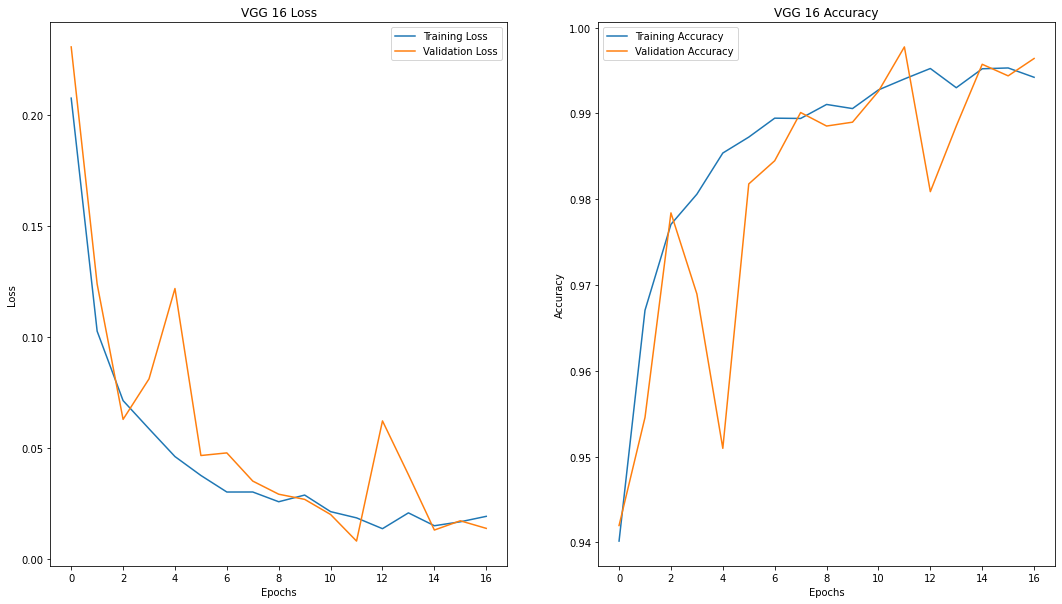

In [ ]:
f, axs = plt.subplots(1,2,figsize=(18,10))
axs[0].plot(vgg_results.history['loss'],label = 'Training Loss')
axs[0].plot(vgg_results.history['val_loss'], label = 'Validation Loss')
axs[1].plot(vgg_results.history['accuracy'], label = 'Training Accuracy')
axs[1].plot(vgg_results.history['val_accuracy'], label = 'Validation Accuracy')
axs[0].set(xlabel='Epochs',ylabel='Loss', title='VGG 16 Loss')
axs[1].set(xlabel = 'Epochs', ylabel='Accuracy', title = 'VGG 16 Accuracy')
axs[1].legend(labels = ['Training Accuracy', 'Validation Accuracy'])
axs[0].legend(labels = ['Training Loss', 'Validation Loss'])
plt.show();

In [ ]:
# vgg.save('/content/drive/MyDrive/project_5_group_3/data/Models/vgg_model')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/project_5_group_3/data/Models/vgg_model/assets


# Conclusion/Recommendations

Adding an additional layer of security for age verification can prove to be useful for parents and organizations alike. By utilizing our binary classification model, organizations can incorporate a facial recognition feature to verify ages for their users and prohibit minors from accessing adult content. This solution also aims to provide companies with preventative measures against possible litigation and public complaints for not adding the necessary security measures. Another application for this model is to detect children in pornographic material and other forms of child sexploitation.

We recommend that this model serves as the basis for classifying children and adults. In order to improve upon this application, one can utilize the OpenCV library to incorporate a real-time facial recognition system that can identify children/adults in real time.